In [1]:
import torch as tc 
from torch import nn, optim 
from torch.utils.data import DataLoader, random_split, Dataset

from torchvision import transforms as T 
from torchvision import datasets 
from torchvision import models 

from torchmetrics import Accuracy 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from tqdm import tqdm 

from PIL import Image

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cpu' if tc.cuda.is_available() else 'cpu' 
device

'cpu'

In [3]:
transform = T.Compose([T.Resize(size = (224, 224)), T.ToTensor()])

In [4]:
class SegmentationDataset(Dataset):
    
    def __init__(self, root, phase):
        
        csv_data = pd.read_csv(f'{root}/metadata.csv')[0:500]
        
        self.image = [f'{root}/{csv_data.image_path[j]}' for j in range(len(csv_data)) if csv_data.split[j] == f'{phase}']
        self.mask  = [f'{root}/{csv_data.mask_path[j]}' for j in range(len(csv_data)) if csv_data.split[j] == f'{phase}']
        
    
    def __getitem__(self, item):
        
        image = self.image[item]
        image = Image.open(image)
        image = transform(image)
        mask  = transform(Image.open(self.mask[item]).convert('L'))
        #mask  = mask.type(tc.long)
        mask = tc.round(mask)
        return image, mask
    
    def __len__(self):
        return len(self.image)

In [5]:
train_dataset = SegmentationDataset('/home/ahmadrezabaqerzadeh/datasets/imageSegmentation', 'train')

In [6]:
valid_dataset = SegmentationDataset('/home/ahmadrezabaqerzadeh/datasets/imageSegmentation', 'test')

In [7]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 256, shuffle = False)

In [8]:
x , y = next(iter(train_loader))

In [9]:
x.shape

torch.Size([128, 3, 224, 224])

In [10]:
y.shape

torch.Size([128, 1, 224, 224])

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    
    train_loss = AverageMeter()
    train_acc = Accuracy(task = 'binary').to(device)
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        
        if epoch is not None:
            tepoch.set_description(f'Epoch={epoch}')
        
        for x, y in tepoch:
            
            x = x.to(device)
            y = y.to(device)
            
            yp = model(x)
            loss = loss_func(yp, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss.update(loss.item())
            train_acc(yp, y)
            
            tepoch.set_postfix(loss = train_loss.avg, accuracy = train_acc.compute().item() * 100)
            
    return model, train_loss.avg, train_acc.compute().item()

In [13]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task = 'binary').to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp, y)

        valid_loss.update(loss.item())
        valid_acc(yp, y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [14]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.LazyConv2d(32, (3, 3), (1, 1), (1, 1))
        self.bn1 = nn.LazyBatchNorm2d()
        self.mpool1= nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.LazyConv2d(64, (3, 3), (1, 1), (1, 1))
        self.bn2 = nn.LazyBatchNorm2d()
        
        self.conv3 = nn.LazyConv2d(32, (3, 3), (1, 1), (1, 1))
        self.bn3 = nn.LazyBatchNorm2d()
        
        self.tconv1 = nn.LazyConvTranspose2d(32, (4, 4), (2, 2), (1, 1))
        self.tbn1 = nn.LazyBatchNorm2d()
        
        self.conv4 = nn.LazyConv2d(32, (3, 3), (1, 1), (1, 1))
        self.bn4 = nn.LazyBatchNorm2d()
        
        self.conv5 = nn.LazyConv2d(1, (3, 3), (1, 1), (1, 1))
        self.bn5 = nn.LazyBatchNorm2d()
        
    def forward(self, x):
        
        y = self.conv1(x).relu()
        y1 = self.bn1(y)
        y = self.mpool1(y1)
        
        y = self.conv2(y).relu()
        y = self.bn2(y)
        
        y = self.conv3(y).relu()
        y = self.bn3(y)
        
        y = self.tconv1(y).relu()
        y = self.tbn1(y)
       
        y = tc.cat([y1, y], dim = 1)
        
        y = self.conv4(y).relu()
        y = self.bn4(y)
        
        y = self.conv5(y).relu()
        y = self.bn5(y)
        
        y = nn.Sigmoid()(y)
        return y

In [15]:
model = Model().to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
model(x.to(device)).shape

torch.Size([128, 1, 224, 224])

In [17]:
optimizer = optim.SGD(model.parameters(), lr = 0.005, momentum = 0.9)
loss_func = nn.BCELoss()

In [18]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []
best_loss = tc.inf 
best_model = [0]
N = 10

In [19]:
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  #valid_loss, valid_acc = validation(model,valid_loader,loss_func)
  
  loss_train_hist.append(train_loss)
  acc_train_hist.append(train_acc)
  
  #loss_valid_hist.append(valid_loss)
  #acc_valid_hist.append(valid_acc)

  #if valid_loss<best_loss:
   # best_loss = valid_loss
   # best_model[0] = model
   # print('model saved!')

Epoch=9: 100%|██████████| 2/2 [00:24<00:00, 12.10s/batch, accuracy=73, loss=0.626]  


In [20]:
imgt = Image.open('/home/ahmadrezabaqerzadeh/datasets/imageSegmentation/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000003.jpg')

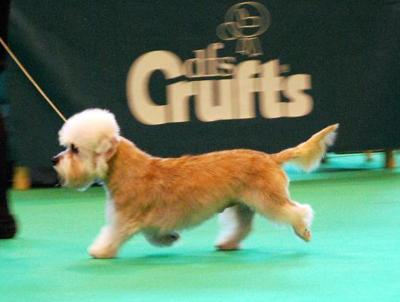

In [21]:
imgt

In [22]:
img = transform(imgt)

In [23]:
yp = model(img.to(device).unsqueeze(0))

In [24]:
yp.shape

torch.Size([1, 1, 224, 224])

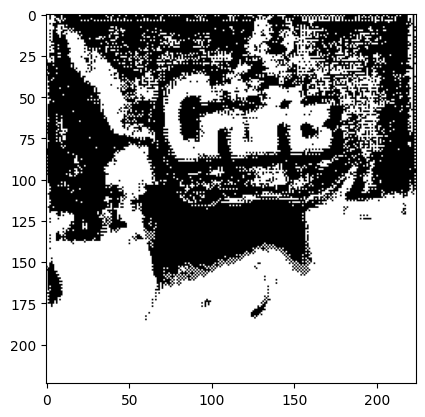

In [28]:
plt.imshow(tc.round(yp.cpu().detach().squeeze()), cmap = 'binary')